In [27]:
!pip install -q torch-cluster 
!pip install -q torch-scatter
!pip install -q torch-sparse
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
#@title Read data
import os
import pandas as pd
import networkx as nx
import matplotlib as mpl
import numpy as np
import random

PRJ_DIR = os.path.join('/','content','drive','MyDrive','Colab Notebooks','eliorc_node2vec')
DATA_DIR = os.path.join(PRJ_DIR,'Facebook-Social-Network-Analysis-master')

# Read data
fb = pd.read_csv(os.path.join(DATA_DIR,'facebook_combined.txt'), delim_whitespace=True, names=['Source', 'Destination'])
fb.head()

,Source,Destination
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [76]:
#contents of one such file, namely '0.featnames'
with open(os.path.join(DATA_DIR,'facebook','0.featnames'), 'r') as f:
        feature_names = f.readlines()
        
feature_names_df = pd.read_csv(os.path.join(DATA_DIR,'facebook','0.featnames'), names=['Feature Names'])
# format of the values in the file : 
# 'feature number' + ' ' + 'feature name' + ';' + 'feature type'
# feature type always starts with 'anonymized feature' 
feature_names_df

,Feature Names
0,0 birthday;anonymized feature 0
1,1 birthday;anonymized feature 1
2,2 birthday;anonymized feature 2
3,3 birthday;anonymized feature 3
4,4 birthday;anonymized feature 4
...,...
219,219 work;start_date;anonymized feature 170
220,220 work;start_date;anonymized feature 171
221,221 work;start_date;anonymized feature 203
222,222 work;start_date;anonymized feature 204


In [77]:
# printing list of unique features in the '0.featnames'
unique_features = []

for i in range(len(feature_names)):
  feature_names[i] = feature_names[i].split(' ', 1)[1]
  feature_names[i] = feature_names[i].rsplit(';' , 1)[0]
  unique_features.append(feature_names[i])

list(set(unique_features))

['work;with;id',
 'languages;id',
 'gender',
 'locale',
 'education;year;id',
 'education;concentration;id',
 'birthday',
 'last_name',
 'work;start_date',
 'first_name',
 'education;classes;id',
 'work;employer;id',
 'location;id',
 'work;end_date',
 'hometown;id',
 'work;position;id',
 'education;degree;id',
 'work;location;id',
 'education;type',
 'education;school;id',
 'education;with;id']

In [78]:
#@title Creating a nested dictionary of all the nodes along with its attributes
def ExtractFeatureNames(path):
    with open(path, 'r') as f:
        feature_names = f.readlines()

    for i in range(len(feature_names)):
        feature_names[i] = feature_names[i].split(' ', 1)[1]
        feature_names[i] = feature_names[i].rsplit('\n' , 1)[0]
        feature_names[i] = feature_names[i].rsplit(';' , 1)
        feature_names[i][1] = feature_names[i][1].rsplit(' ' , 1)[1]
        
    return feature_names

#storing all the numbers of different files in a list
l = ['0','107','348','414','686','698','1684','1912','3437','3980']

node_features = []

# extracting features - 'location;id' and 'education;school;id'
for i in l:
    df = pd.read_csv(os.path.join(DATA_DIR,'facebook',i +'.feat'), 
                     delim_whitespace=True, 
                     names=pd.MultiIndex.from_tuples(ExtractFeatureNames(os.path.join(DATA_DIR,'facebook',i +'.featnames')))).T
    node_features.append(df.loc[['location;id','education;school;id']])

node_attributes = {}
for i in node_features:
    a = {j : i[i[j] == 1][j].index.tolist()[:2] for j in i.columns if len(i[i[j] == 1][j].index.tolist())>1 and 
                                                                 i[i[j] == 1][j].index.tolist()[0][0] == 'location;id'}
    node_attributes.update(a)

#creating the nested dictionary
for k,v in node_attributes.items():
    node_attributes[k] = {i[0] : i[1] for i in node_attributes[k]}
    
#sorting the dictionary
node_attributes = {i[0]: i[1] for i in sorted(node_attributes.items())}

In [79]:
#@title Dropping unwanted nodes from fb dataframe
#dropping the extra nodes from 'fb' that are not in 'node_attributes' 
no_att_source = list(set([i for i in fb.Source]) - set(node_attributes.keys()))
no_att_dest = list(set([i for i in fb.Destination]) - set(node_attributes.keys()))

#finding indices of the above nodes in fb and dropping them
idx = []
for i in no_att_source:
    idx.extend(fb.index[fb.Source == i].tolist())
    
fb.drop(list(set(idx)), axis=0, inplace=True)
    
idx = []    
for i in no_att_dest:    
    idx.extend(fb.index[fb.Destination == i].tolist())
    
fb.drop(list(set(idx)), axis=0, inplace=True)

In [80]:
#@title Creating graph
#creating a list of node pair tuples from the 'fb' dataframe
existing_edges = [(fb.iloc[i,0],fb.iloc[i,1]) for i in range(fb.shape[0])]

G = nx.Graph()
for i in node_attributes.keys():
    G.add_node(i)

G.add_edges_from(existing_edges)
print("------Before Dropping nodes with low degree (<3)-----")
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

------Before Dropping nodes with low degree (<3)-----
Number of nodes 1447
Number of edges 18476
Average degree 25.536973047684864


In [81]:
fb = pd.DataFrame(data=list(G.edges()), columns=['Source', 'Destination'])
fb.head()

,Source,Destination
0,2,116
1,2,226
2,2,326
3,3,25
4,3,67


In [83]:
nodes = pd.concat([fb['Source'],fb['Destination']]).unique()
print(type(nodes), len(nodes))

<class 'numpy.ndarray'> 1418


In [85]:
#@title Creating graph
#creating a list of node pair tuples from the 'fb' dataframe
existing_edges = [(fb.iloc[i,0],fb.iloc[i,1]) for i in range(fb.shape[0])]

G = nx.Graph()
fb_nodes = pd.concat([fb['Source'],fb['Destination']]).unique()
for i in fb_nodes:
    G.add_node(i)

G.add_edges_from(existing_edges)
print("------Before Dropping nodes with low degree (<3)-----")
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

------Before Dropping nodes with low degree (<3)-----
Number of nodes 1418
Number of edges 18476
Average degree 26.059238363892806


In [86]:
#@title Creating Adjacency Matrix

nodelist = list(G.nodes())
adj_G = nx.to_numpy_array(G, nodelist = nodelist)
print(str(adj_G.shape)+'\n')
adj_G

(1418, 1418)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:
non_existing_edges_40000 = []
while(len(non_existing_edges_40000) < 40000):
    source_idx = random.randint(0, adj_G.shape[0]-1)
    destination_idx = random.randint(0, adj_G.shape[1]-1)
    if source_idx == destination_idx or adj_G[source_idx, destination_idx] == 1:
        continue

    if nx.has_path(G, nodelist[source_idx], nodelist[destination_idx]):
        non_existing_edges_40000.extend([(nodelist[source_idx],nodelist[destination_idx])])
    

non_existing_edge_df = pd.DataFrame(data = non_existing_edges_40000, columns =['Source', 'Destination'])
non_existing_edge_df['Connection'] = 0
non_existing_edge_df.head()

,Source,Destination,Connection
0,475,2131,0
1,202,3196,0
2,2436,2052,0
3,2386,102,0
4,222,1853,0


In [91]:
def GettingRemoveableEdges(origin_G, origin_graph_df):
    # Create a list of all indices of the node pairs in the fb dataframe,
    # which when removed won’t change the structure of our graph
    
    # create a copy
    temp_graph_df = origin_graph_df.copy()
    temp_G = nx.from_pandas_edgelist(origin_graph_df, "Source", "Destination",
                                    create_using=nx.Graph())
    
    # for storing removable edges
    removable_edges_indices = []
    
    # number of connected components and nodes of G
    ncc = nx.number_connected_components(origin_G)
    number_of_nodes = len(origin_G.nodes)
    
    # for each node pair we will be removing a node pair and creating a new graph,
    # and check if the number of connected components and the number of nodes
    # are the same as the original graph
    for i in origin_graph_df.index.values:
        if len(removable_edges_indices) >= len(origin_graph_df.index)//2:
            break

        if (i % 100) == 0:
            print(f"row {i}: {origin_graph_df.iloc[i, 0]}, {origin_graph_df.iloc[i, 1]}")
        
        temp_G.remove_edge(origin_graph_df.iloc[i, 0], origin_graph_df.iloc[i, 1])
        if len(temp_G.nodes) == number_of_nodes and nx.number_connected_components(temp_G) == ncc:
            #temp_G.remove_edge(origin_graph_df.iloc[i, 0], origin_graph_df.iloc[i, 1])
            removable_edges_indices.append(i)
        else:
            temp_G.add_edge(origin_graph_df.iloc[i, 0], origin_graph_df.iloc[i, 1])

    with open(os.path.join(PRJ_DIR,'fb_removable_edges_indices.txt'), 'w') as f:
        removable_edges_indices = [str(elem.item()) for elem in removable_edges_indices]
        file_lines = "\n".join(removable_edges_indices)
        f.write(file_lines)

    with open(os.path.join(PRJ_DIR,'fb_removable_edges_indices.txt'), 'r') as f:
        removable_edges_indices = f.readlines()
        removable_edges_indices = [int(elem) for elem in removable_edges_indices]

    return removable_edges_indices

if os.path.isfile(os.path.join(PRJ_DIR,'fb_removable_edges_indices.txt')):
    print("Already have file!")
    with open(os.path.join(PRJ_DIR,'fb_removable_edges_indices.txt'), 'r') as f:
        removable_edges_indices = f.readlines()
        removable_edges_indices = [int(elem) for elem in removable_edges_indices]
else:
    print("Not have file yet!")
    removable_edges_indices = GettingRemoveableEdges(G, fb)

Already have file!


In [92]:
#@title Creating Dataframe of Removable Edges

removeable_edge_df = fb.loc[removable_edges_indices]
removeable_edge_df['Connection'] = 1
 
removeable_edge_df.head()

,Source,Destination,Connection
0,2,116,1
1,2,226,1
3,3,25,1
4,3,67,1
5,3,142,1


In [93]:
#@title Creating Subgraph
non_existing_edge_df = non_existing_edge_df.append(removeable_edge_df[['Source', 'Destination', 'Connection']],
                ignore_index=True)

edges_G_past = fb.drop(index=removeable_edge_df.index.values)

G_new = nx.from_pandas_edgelist(edges_G_past, "Source", "Destination",
                               create_using=nx.Graph())

print('Number of nodes', len(G_new.nodes))
print('Number of edges', len(G_new.edges))
print('Average degree', sum(dict(G_new.degree).values()) / len(G_new.nodes))

Number of nodes 1418
Number of edges 9238
Average degree 13.029619181946403


<ipython-input-93-b8f500e20bdb>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_existing_edge_df = non_existing_edge_df.append(removeable_edge_df[['Source', 'Destination', 'Connection']],


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/eliorc_node2vec/'
!pwd

/content/drive/MyDrive/Colab Notebooks/eliorc_node2vec
/content/drive/MyDrive/Colab Notebooks/eliorc_node2vec


In [94]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

edges_tensor = torch.from_numpy(edges_G_past.to_numpy())
edges_tensor = torch.permute(edges_tensor, (1, 0))


node2vec = Node2Vec(edge_index = edges_tensor,
                    embedding_dim = 128,
                    walk_length = 16,
                    context_size = 10,
                    walks_per_node = 20).to(device)

loader = node2vec.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(list(node2vec.parameters()), lr=0.01)

In [95]:
node2vec

Node2Vec(4022, 128)

In [96]:
def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 150):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01, Loss: 5.2278


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 02, Loss: 4.0549


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 03, Loss: 3.1268


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 04, Loss: 2.4226


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 05, Loss: 1.9225


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 06, Loss: 1.5638


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 07, Loss: 1.3079


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 08, Loss: 1.1265


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.0045


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.9206


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.8663


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.8314


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.8079


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.7937


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.7837


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.7754


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.7694


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.7649


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.7601


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.7570


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.7532


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.7503


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.7474


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.7450


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.7431


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.7410


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.7391


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.7378


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.7362


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.7349


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.7336


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.7326


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.7312


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.7303


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.7297


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.7288


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.7281


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.7275


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.7265


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.7260


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.7255


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.7250


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.7246


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.7243


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.7238


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.7232


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.7231


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.7227


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.7222


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.7220


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.7219


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.7215


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.7215


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.7210


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.7208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.7208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.7207


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.7205


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.7204


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.7203


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.7199


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.7199


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.7202


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.7196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.7196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.7197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.7193


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.7188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.7188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.7188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.7188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.7188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.7188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 100, Loss: 0.7189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 101, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 102, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 103, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 104, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 105, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 106, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 107, Loss: 0.7193


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 108, Loss: 0.7190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 109, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 110, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 111, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 112, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 113, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 114, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 115, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 116, Loss: 0.7191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 117, Loss: 0.7193


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 118, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 119, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 120, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 121, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 122, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 123, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 124, Loss: 0.7192


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 125, Loss: 0.7193


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 126, Loss: 0.7195


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 127, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 128, Loss: 0.7193


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 129, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 130, Loss: 0.7196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 131, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 132, Loss: 0.7195


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 133, Loss: 0.7197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 134, Loss: 0.7195


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 135, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 136, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 137, Loss: 0.7197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 138, Loss: 0.7195


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 139, Loss: 0.7197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 140, Loss: 0.7196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 141, Loss: 0.7194


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 142, Loss: 0.7196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 143, Loss: 0.7195


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 144, Loss: 0.7196


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 145, Loss: 0.7199


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 146, Loss: 0.7197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 147, Loss: 0.7198


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 148, Loss: 0.7197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 149, Loss: 0.7198


In [104]:
node2vec.embedding.weight.size()[0]

4022

In [105]:
st_tensor = torch.arange(node2vec.embedding.weight.size()[0], device=device)
print(st_tensor.size())
embedding_nodes = node2vec(st_tensor)
print(embedding_nodes.size())

edge_features = [
    (embedding_nodes[i].detach().cpu().numpy() + embedding_nodes[j].detach().cpu().numpy()) 
    for i,j in zip(non_existing_edge_df['Source'], non_existing_edge_df['Destination'])
]

torch.Size([4022])
torch.Size([4022, 128])


In [108]:
#@title Applying Random algorithm Forest with GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

X = np.array(edge_features)  
y = non_existing_edge_df['Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#classifier
random_forest_clf = RandomForestClassifier()
 
# parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}
 
# model
grid_random_forest_acc = GridSearchCV(random_forest_clf, param_grid = param)
 
# train the model
grid_random_forest_acc.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_random_forest_acc.best_params_)
print('Grid best score (accuracy): ', grid_random_forest_acc.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_random_forest_auc = GridSearchCV(random_forest_clf, param_grid = param, scoring = 'roc_auc')
grid_random_forest_auc.fit(X_train, y_train)
predict_proba = grid_random_forest_auc.predict_proba(X_test)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_random_forest_auc.best_params_)
print('Grid best score (AUC): ', grid_random_forest_auc.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 15, 'n_estimators': 50}
Grid best score (accuracy):  0.9021608998414354
Test set AUC:  0.96707489874907
Grid best parameter (max. AUC):  {'max_depth': 15, 'n_estimators': 100}
Grid best score (AUC):  0.9624300983014866


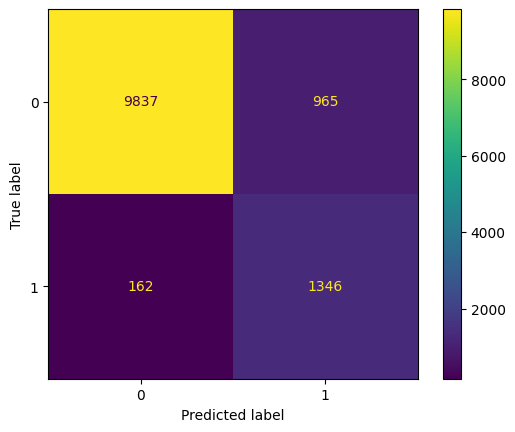

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay

pred = grid_random_forest_auc.predict(X_test)
cm = confusion_matrix(pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_random_forest_auc.classes_)
disp.plot()

Text(0, 0.5, 'True Positive Rate')

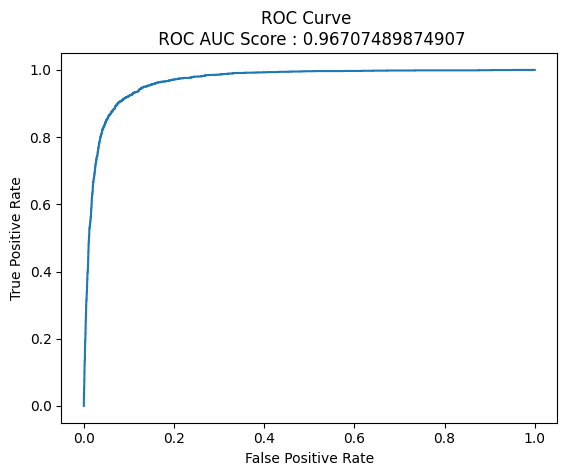

In [110]:
false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

mpl.pyplot.plot(false_positive_rate,true_positive_rate)
mpl.pyplot.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
mpl.pyplot.xlabel('False Positive Rate')
mpl.pyplot.ylabel('True Positive Rate')